# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
# dir = "/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin"
# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


In [2]:
# print(len(ext))

## 2. Discretization and other inputs

In [4]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('top_elev.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
   
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (23.0, 29.0)  #forced riparian area
rip_cols_forced = (0.0, 50.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (0.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (0.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
rech_zone=np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

## Well1: 
# pumping1 = 0 #m3/day 
# well1_xy= [38000, 29000] #xy location of well 
# well1_row = np.floor((nrow)-(well1_xy[1]/dy)) #convert the y location to a row
# well1_col=np.floor(well1_xy[0]/dx) #convert the x location to a column
# well1_loc = (2,well1_row, well1_col) #Well loc shoudl be layer, row, column
# print("well1 location(layer, col, row)", well1_col, well1_row)
# #print(well1_loc)

#print(well1_col)
#print(well1_row)


## Well2 
#pumping = 0 #m3/day  
#well1_xy= [38000, 29000] #xy location of well 
#well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
#well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
#well1_loc = (2,well1_row,well_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)


## Well3 
#pumping = 0 #m3/day  
#well1_xy= [38000, 29000] #xy location of well 
#well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
#well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
#well1_loc = (2,well1_row,well_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)

# wel1 = [0, well1_col, well1_row, pumping1]
# wel1_spd = {0: [wel1]}
# print(wel1_spd)

## Boundary conditions
h_right = 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)


### Layering

In [5]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 




## Boundary Conditions

In [6]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

# ibound[0,25,0]=1
#middle layer no flow region
#ibound[1,42:49,0:7] = 0
#bottom layer no flow region
#ibound[2,40:49,0:9] = 0

#setup initial heads as 1 everywhere except on the boundaries
#H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
#H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
np.set_printoptions(threshold=np.inf)
#print(ET_zone.shape)
#print(ET_zone)

# print(ibound[0])
# print(ibound[1])
# print(ibound[2])
# np.savetxt("write0.csv", ibound[0], delimiter=",")
# np.savetxt("write1.csv", ibound[1], delimiter=",")
# np.savetxt("write2.csv", ibound[2], delimiter=",")

In [7]:
#DEFINE RIVERS
riv_row= 25
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[25,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

### Run Modflow

In [14]:
#create model object
modelname = "Scenario_1"
moddir="/Applications/MODFLOW/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
# wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel1_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   
m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')
  

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0

check method not implemented for PCG Package.

RIV PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    stage below cell bottom
    rbot below cell bottom
    RIV stage below rbots


RCH PACKAGE DATA VALIDATION:
  1

### Plot bounds

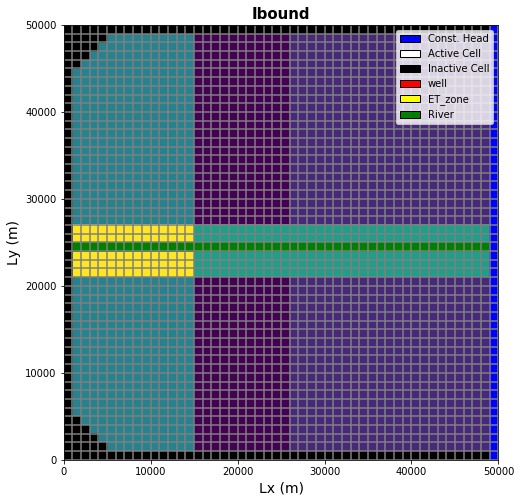

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound[0])



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    #mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

## Read outputs and plot heads

<ipython-input-16-16c85b833718>:22: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')


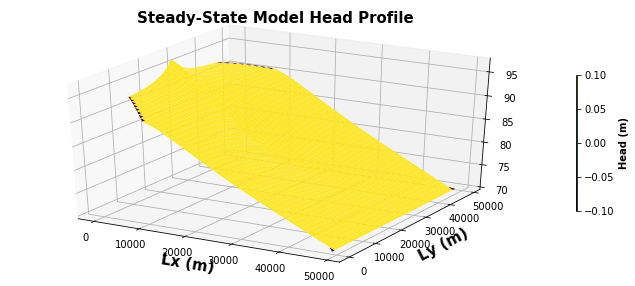

In [16]:

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#head = headobj.get_alldata()
head = headobj.get_alldata(nodata=-9.9998999e+02)
# print(head[0][0][27])
# print(head[0][1][27])
# print(head[0][2][27])

#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0][2])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=150).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

# plt.figure(figsize=(9,9)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
# #riv_plot = modelmap.plot_bc(ftype='RIV') #plot river cells
# #chd_plot = modelmap.plot_bc(ftype='CHD') #plot ghb cells
# contour_levels = np.linspace(70,95,1) #set contour levels for contouring head
# head_contours = modelmap.contour_array(head[0][0], masked_values=[-1.0000000e+30], levels=contour_levels) #create head contours
# #flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
# #display parameters
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Head', fontsize = 13, fontweight = 'bold')
# plt.colorbar(head_contours)
# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'), 
#                    mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),
#                    mp.patches.Patch(color='white',label='Active Cell',ec='black')],
#                    bbox_to_anchor=(1.8,1.0)) #create legend
# plt.show(modelmap)    

## Plot heads and cross-section

[      nan       nan       nan       nan       nan 92.24112  92.075836
 91.80513  91.47763  91.09104  90.77492  90.39065  89.949486 89.45652
 88.91434  88.32428  87.73277  87.141075 86.55027  85.96129  85.38591
 84.810875 84.237526 83.66689  83.099785 82.53679  81.97837  81.42481
 80.87629  80.332855 79.79447  79.26098  78.73218  78.207756 77.68738
 77.17062  76.65706  76.14619  75.637505 75.13046  74.624504 74.119026
 73.61343  73.107025 72.5991   72.088806 71.57517  71.056984 70.53266
 70.      ]


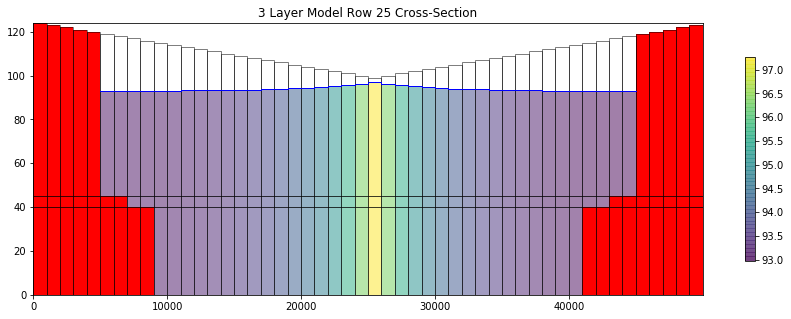

In [17]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 1}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

print(head[0][0][1][:])

In [18]:
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1)
#print(leakage[0])
flux = np.array(range(nper))

for i in range(nper):
    ##print("Stream Leakage for Stress period %s"%i)
    perflux = 0
    for k in range(len(leakage[0])):
        #print(leakage['sp%s'%i][0][k][1])
        #perflux = perflux + leakage['sp%s'%i][0][k][1]
        flux[i] = flux[i] + leakage[0][k][1]
    #print(perflux)
print(flux)    

[6313]


## Adding particles

In [53]:
moddirmp="/Applications/MODFLOW/mp7"

mpname=os.path.join(modelname + '_mp')
print(mpname)

Scenario_1_mp


In [54]:
#Set the rante of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
locsb = [[0, 0, 0, 0, nrow - 1, ncol-1]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg2]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='backward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mp.add_package(rch)
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: /Applications/MODFLOW/mp7

MODPATH Version 7.2.001   
Program compiled Jan 27 2020 10:33:17 with GFORTRAN compiler (ver. 8.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
       256 particles terminated at weak source cells.
      2078 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


['MPBAS', 'MPSIM', 'RCH']

## Read in Particles

In [55]:
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #pathlines
eall = e.get_alldata()  #endpoints

#Get locations to extract pathline
riv_locs = list(range(1201, 1250))
priver = p.get_destination_pathline_data(dest_cells=riv_locs)
eriver= e.get_destination_endpoint_data(dest_cells=riv_locs)


#Code just for reference of what's going on with the rivers
# #DEFINE RIVERS
# riv_row= 25
# riv_sp = [] #create list to store all river cells for stress period 1
# k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
# sed_thick = 1 #thickness of riverbed sediment in m
# cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
# r_stage = .5 #stage in river (stress period 1)
# r_bott = ztop[25,:] #river bottom
# #print(r_bott)
# for i in range(1,ncol):
#     riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
# #print(riv_spd)
# #create dictionary of stress period data
# riv_spd = {0: riv_sp}
# #print(riv_spd)

## Grabbing out particles

(numpy.record, [('particleid', '<i4'), ('particlegroup', '<i4'), ('particleidloc', '<i4'), ('status', '<i4'), ('time0', '<f4'), ('time', '<f4'), ('node0', '<i4'), ('k0', '<i4'), ('xloc0', '<f4'), ('yloc0', '<f4'), ('zloc0', '<f4'), ('x0', '<f4'), ('y0', '<f4'), ('z0', '<f4'), ('zone0', '<i4'), ('initialcellface', '<i4'), ('node', '<i4'), ('k', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('zone', '<i4'), ('cellface', '<i4')])

Here is a list of variable names
('particleid', 'particlegroup', 'particleidloc', 'status', 'time0', 'time', 'node0', 'k0', 'xloc0', 'yloc0', 'zloc0', 'x0', 'y0', 'z0', 'zone0', 'initialcellface', 'node', 'k', 'xloc', 'yloc', 'zloc', 'x', 'y', 'z', 'zone', 'cellface')

This is the way to access a row
(1, 0, 1, 5, 0., 49757268., 55, 0, 0.5, 0.5, 0.5, 5500., 48500., 68.62056, 0, 0, 1251, 0, 0., 1., 0.9997885, 1000., 25000., 97.256424, 0, 1)


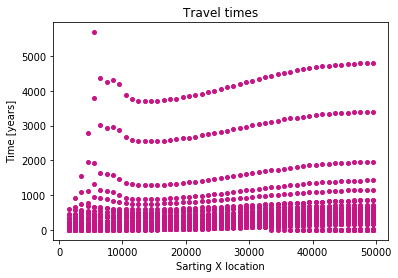

In [56]:
#Grabbing some info about particles
#type(eall)    # checke the data type of eall 
print(eall.dtype) #print out all the columns and their data types
print()
print('Here is a list of variable names')
print(eall.dtype.names)  #print out just the names

#There are two ways to access a column of data: 
#1. 
#print('This is the first way of accessing a column')
print()
data_eall=eall.view(np.recarray)
#print(data_eall.particleid)

#2. 
#print('This is the second way of accessing a column')
#print(eall['particleid'])

#If you want to grab out one row of data (i.e. the complete start stop record for one particle)
print('This is the way to access a row')
print(data_eall[1])

#Now make a simple plot of particle starting x locaiton and ending y location 
x=eall['x0']
y=eall['time']/8760
plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='')
plt.title('Scatter plot pythonspot.com')
plt.xlabel('Sarting X location')
plt.ylabel('Time [years]')
plt.title("Travel times")
plt.savefig('Travel_Times.png')

## Plot Particle Pathlines

<Figure size 432x288 with 0 Axes>

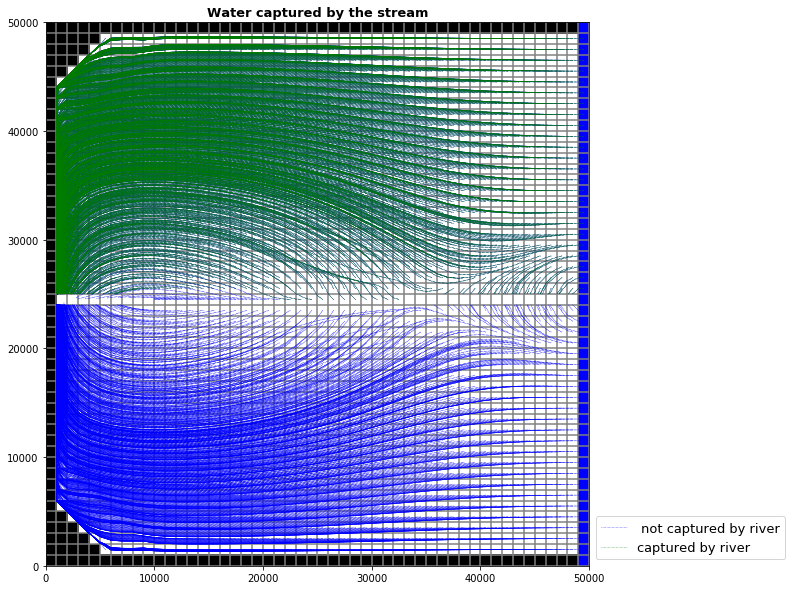

In [57]:
# f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# ax = axes[0]
# ax.set_aspect('equal')
# ax.set_title('Flowlines')
# mm = flopy.plot.PlotMapView(model=m, ax=ax)
# mm.plot_grid(lw=0.5)
# mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by river') #,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(priver, layer='all', color='green', lw=0.5, linestyle=':', label='captured by river') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# #mm.plot_endpoint(eall, direction='ending', colorbar=True, shrink=0.5);
# mm.plot_endpoint(eriver, direction='starting', colorbar=True, shrink=0.5)
# mm.ax.legend();

# ax = axes[1]
# ax.set_aspect('equal')
# ax.set_title('Well Capture Area')
# mm = flopy.plot.PlotMapView(model=m, ax=ax)
# mm.plot_endpoint(ewell, direction='starting', colorbar=True, shrink=0.5);
#mm.plot_endpoint(eall, direction='ending', colorbar=True, shrink=0.5);
# mm.plot_grid(lw=0.5)
#mm.plot_pathline(prb, layer='all', color='green', lw=0.5, linestyle=':', label='captured by rivers')

plt.tight_layout()

fig = plt.figure(figsize=(10, 10))
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

modelmap.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label=' not captured by river') #,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.plot_pathline(priver, layer='all', color='green', lw=0.5, linestyle=':', label='captured by river') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
modelmap.ax.legend(loc='lower left', bbox_to_anchor=(1, 0.00),fontsize=13);
plt.title('Water captured by the stream',fontweight='bold',fontsize=13)

# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
#                    mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black')],)

plt.show(modelmap)

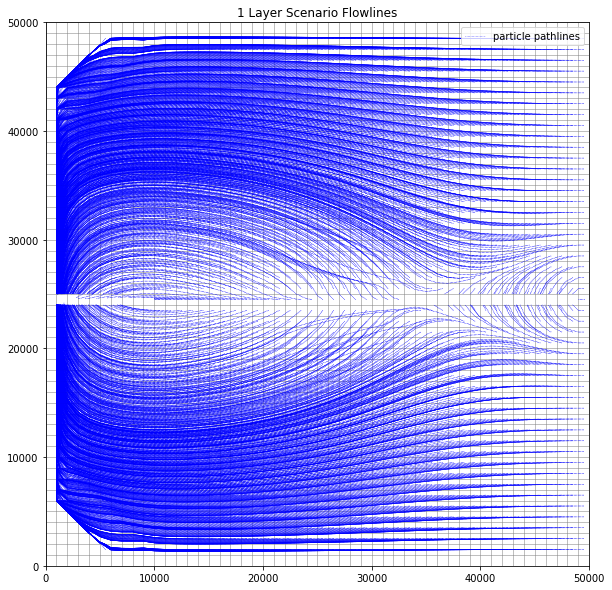

In [58]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('1 Layer Scenario Flowlines')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='particle pathlines') #,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell3, layer='all', color='red', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell1, layer='all', color='orange', lw=0.5, linestyle=':', label='1 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();
#plt.tight_layout();
#plt.savefig('Pathlines.png')